# Preprocessing and loading

In [ ]:
import pandas as pd
df = pd.read_csv("/kaggle/input/llm-lab2/train.csv")
df

Loading into pandas df and applying regex to remove unnecessary characters

In [ ]:
import re
# Correct way to select columns for applying a function:
df[["question1", "question2"]] = df[["question1", "question2"]].map(lambda x: str(x).lower())
df[["question1", "question2"]] = df[["question1", "question2"]].map(lambda x: re.sub(r"[^a-z ]", "", str(x)))
df = df[["question1", "question2"]]
df

Splitting the sentences into words

In [ ]:
df = df.map(lambda x: x.split())
df

Converting to list of lists

In [ ]:
l = list(df["question1"])
d = list(df["question2"])
l = l + d
len(l)

# CBOW Word2Vec Model

This code implements a Continuous Bag of Words (CBOW) model using PyTorch. It preprocesses a corpus by creating a vocabulary and mapping words to indices, then generates training data by creating context-target pairs based on a specified window size. 

The CBOW model consists of an embedding layer and a linear layer for predicting the target word from context words. It uses CrossEntropyLoss for training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import defaultdict

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)  # Predict target word
        self.loss_fn = nn.CrossEntropyLoss()  # Softmax over vocabulary

    def forward(self, context_words):
        context_vec = self.embeddings(context_words)  # (batch_size, context_size, embedding_dim)
        context_vec = context_vec.mean(dim=1)  # Average embeddings across context words
        output = self.linear(context_vec)  # Predict target word
        return output

def preprocess_corpus(corpus):
    """Create vocabulary and map words to indices."""
    word_freq = defaultdict(int)
    for sentence in corpus:
        for word in sentence:
            word_freq[word] += 1

    word2idx = {word: i for i, word in enumerate(word_freq.keys())}
    idx2word = {i: word for word, i in word2idx.items()}
    vocab_size = len(word2idx)

    return word2idx, idx2word, vocab_size

def generate_training_data(corpus, word2idx, window_size=2):
    """Generate (context, target) pairs for CBOW."""
    training_data = []
    for sentence in corpus:
        sentence_indices = [word2idx[word] for word in sentence if word in word2idx]
        for i in range(window_size, len(sentence_indices) - window_size):
            context = (
                sentence_indices[i - window_size:i] + sentence_indices[i + 1:i + 1 + window_size]
            )
            target = sentence_indices[i]
            training_data.append((context, target))
    return training_data

Hyperparameters are initialized

In [ ]:
window_size = 2
learning_rate = 0.001
epochs = 10
batch_size = 4096

Vocabulary and word to index and index to word dictionaries are generated. The corpus is converted into context, target pairs for training

In [ ]:
# Preprocess corpus
word2idx, idx2word, vocab_size = preprocess_corpus(l)
training_data = generate_training_data(l, word2idx, window_size)

# Convert training data to tensors
X_train = torch.tensor([x[0] for x in training_data], dtype=torch.long, device=device)
y_train = torch.tensor([x[1] for x in training_data], dtype=torch.long, device=device)

# # Initialize model, optimizer
model = CBOW(vocab_size, 100).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
vocab_size

# Training

In [ ]:
from tqdm import tqdm
for epoch in range(epochs):
    total_loss = 0
    with tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
        for i in pbar:
            context_batch = X_train[i:i+batch_size]  # Context words
            target_batch = y_train[i:i+batch_size]  # Target word

            optimizer.zero_grad()
            predictions = model(context_batch)
            loss = model.loss_fn(predictions, target_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=total_loss)  # Update progress bar with loss

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# Get word embeddings
def get_word_vector(word):
    """Retrieve the embedding for a given word."""
    if word in word2idx:
        return model.embeddings.weight[word2idx[word]].detach().cpu().numpy()
    else:
        return None

# Example: Get embedding for 'deep'
print("Vector for 'deep':", get_word_vector("deep"))

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
model.load_state_dict(torch.load("/kaggle/input/word2vec/pytorch/default/1/model(1).pth"))

# Custom t-sne

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
class TSNE_custom:
    def __init__(self, n_components=2, perplexity=30.0, learning_rate=200.0, n_iter=100):
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter
    def _compute_pairwise_affinities(self, X):
        n_samples = X.shape[0]
        distances = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
        distances = np.clip(distances, 1e-10, None)
        affinities = np.exp(-distances ** 2 / (2 * self.perplexity ** 2))
        affinities /= np.sum(affinities, axis=1, keepdims=True)
        return affinities
    def _compute_low_dim_affinities(self, Y):
        n_samples = Y.shape[0]
        distances = np.linalg.norm(Y[:, np.newaxis] - Y, axis=2)
        distances = np.clip(distances, 1e-10, None)
        affinities = 1 / (1 + distances ** 2)
        affinities /= np.sum(affinities, axis=1, keepdims=True)
        return affinities
    
    def fit_transform(self, X):
        n_samples, n_features = X.shape
        Y = np.random.randn(n_samples, self.n_components)
        affinities = self._compute_pairwise_affinities(X)
        for i in range(self.n_iter):
            print(i)
            low_dim_affinities = self._compute_low_dim_affinities(Y)
            gradient = 4 * (affinities - low_dim_affinities)[:, :, np.newaxis] * (Y[:, np.newaxis] - Y)
            gradient = np.clip(gradient, -1e10, 1e10)
            Y -= self.learning_rate * np.sum(gradient, axis=1)
        return Y

In [ ]:
def plot_embeddings(embeddings, labels):
    plt.figure(figsize=(16, 16))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

Plotting custom t-sne on a subset of 500 words

In [ ]:
import random

# Select a random subset of words
subset_size = 500  # Adjust based on available RAM
selected_words = random.sample(list(word2idx.keys()), min(subset_size, len(word2idx)))
word_vectors = np.array([model.embeddings.weight[word2idx[word]].detach().cpu().numpy() for word in selected_words])
labels = selected_words

In [ ]:
tsne = TSNE_custom(n_components=2, perplexity=40, n_iter=100)
low_dim_embeddings = tsne.fit_transform(word_vectors)

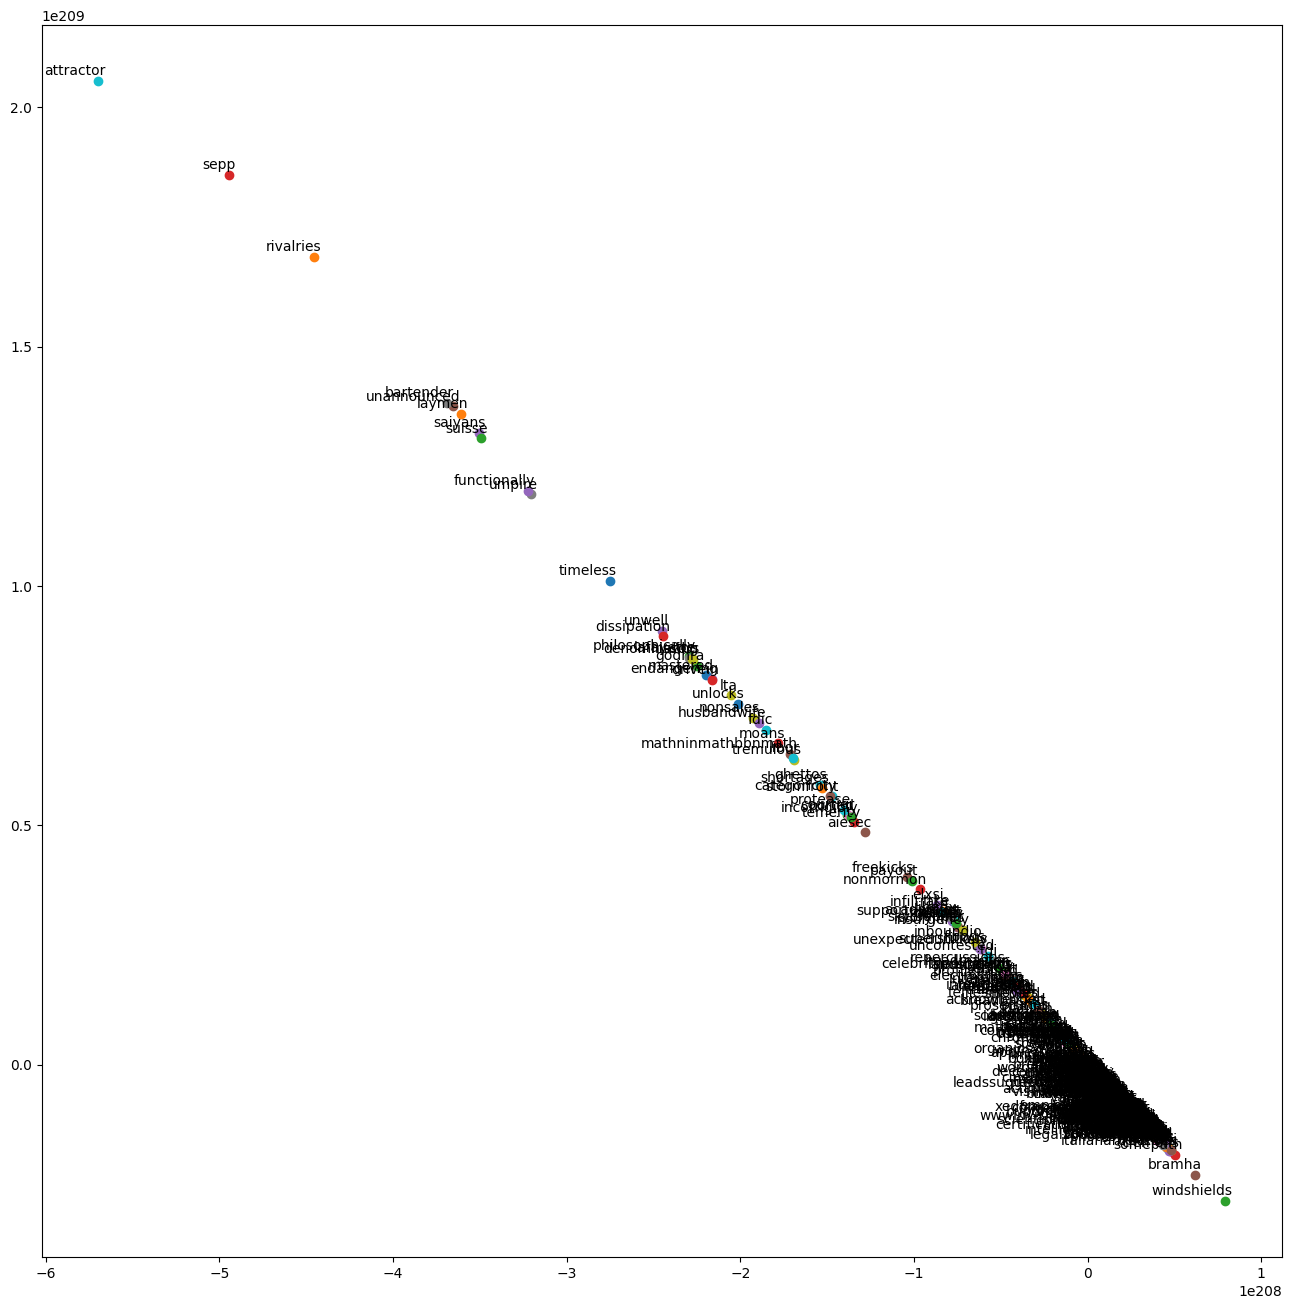

In [59]:
plot_embeddings(low_dim_embeddings, labels)

# Sklearn t-sne

In [ ]:
from sklearn.manifold import TSNE
sklearn_tsne = TSNE(n_components=2, perplexity=40, n_iter=250, random_state=23)
sklearn_low_dim_embeddings = sklearn_tsne.fit_transform(word_vectors)

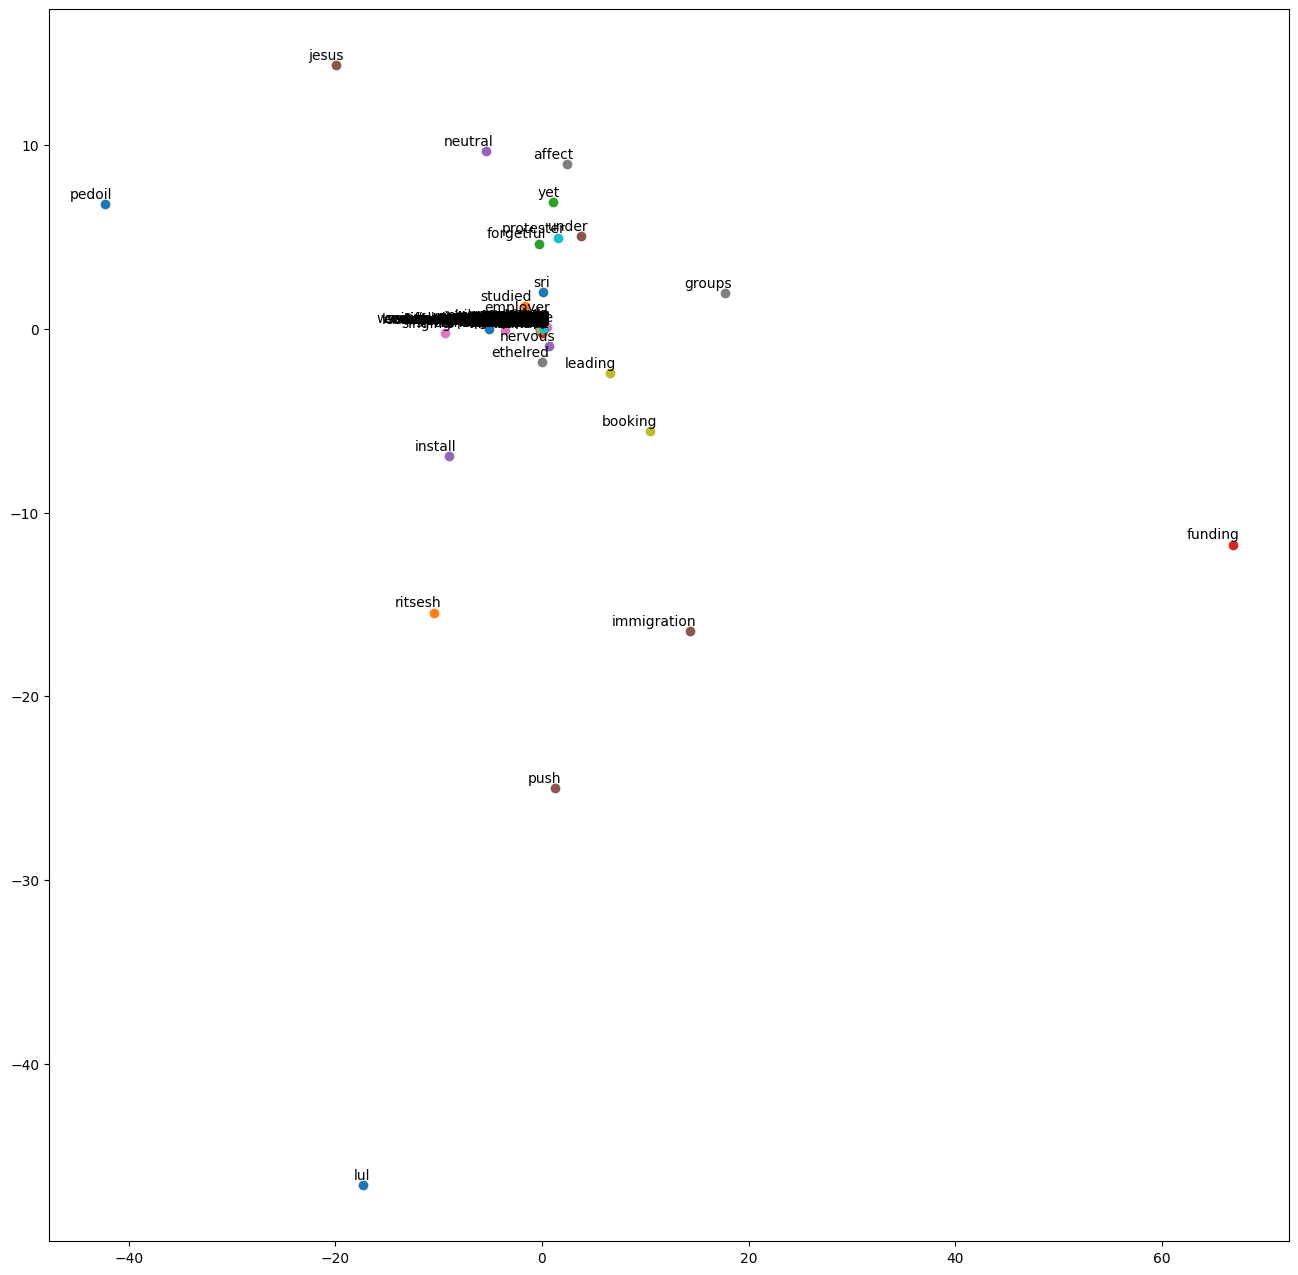

In [60]:
plot_embeddings(sklearn_low_dim_embeddings, labels)

# Prediction 

In [61]:
import torch
import numpy as np

def get_word_vector(word, model, word2idx):
    """Retrieve the word embedding for a given word."""
    if word in word2idx:
        return model.embeddings.weight[word2idx[word]].detach().cpu().numpy()
    else:
        return None

def most_similar(word, model, word2idx, idx2word, top_n=10):
    """Find the top-N most similar words to a given word."""
    if word not in word2idx:
        return f"'{word}' not in vocabulary"
    
    # Get word vector
    word_vector = get_word_vector(word, model, word2idx)

    # Get all word vectors
    all_vectors = model.embeddings.weight.detach().cpu().numpy()

    # Compute cosine similarity
    similarities = np.dot(all_vectors, word_vector) / (np.linalg.norm(all_vectors, axis=1) * np.linalg.norm(word_vector))

    # Get top-N similar words (excluding the word itself)
    top_indices = similarities.argsort()[-top_n-1:-1][::-1]  # Get indices of top-N similar words
    top_words = [(idx2word[idx], similarities[idx]) for idx in top_indices]

    return top_words

# Example usage
print(most_similar("universe", model, word2idx, idx2word))
print(most_similar("trump", model, word2idx, idx2word))

[('universes', 0.5319863), ('world', 0.5116874), ('wiles', 0.47855642), ('civilization', 0.47816014), ('phenomenal', 0.47269052), ('weasley', 0.46879792), ('earth', 0.4680995), ('omnitrix', 0.46412528), ('planet', 0.4637864), ('langerhans', 0.4557348)]
[('trumps', 0.59460634), ('coconspired', 0.47769842), ('rico', 0.44539374), ('hillary', 0.43370166), ('nonchristians', 0.42846426), ('hardy', 0.42519832), ('mrtrump', 0.4223104), ('afrojack', 0.42207506), ('cristiano', 0.42020965), ('goodrx', 0.41934165)]
